In [1]:
%tensorflow_version 2.x
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd
import os


import warnings
warnings.filterwarnings("ignore" , category = UserWarning , module = "bs4")

print(os.listdir("../"))

['etc', 'usr', 'media', 'sys', 'proc', 'opt', 'var', 'sbin', 'bin', 'lib64', 'tmp', 'home', 'lib', 'run', 'boot', 'mnt', 'root', 'dev', 'srv', '.dockerenv', 'datalab', 'tools', 'swift', 'tensorflow-1.15.2', 'content', 'lib32']


In [3]:
# submission  = "https://raw.githubusercontent.com/saras108/movie_review/master/sampleSubmission.csv"
df_test = "https://raw.githubusercontent.com/saras108/movie_review/master/test.tsv"
df_train = "https://raw.githubusercontent.com/saras108/movie_review/master/train.tsv"

# df_submission  = pd.read_csv(submission)
test  = pd.read_csv(df_test , sep='\t')
train  = pd.read_csv(df_train , sep='\t')

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re

from tqdm import tqdm
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
from keras.utils import to_categorical
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense , Dropout , Embedding, LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.models import Sequential
tf.random.set_seed(123)
random.seed(123)

In [6]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [7]:
train.shape

(156060, 4)

In [8]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [9]:
test.shape

(66292, 3)

In [10]:
def clean_sentence(df):
  reviews = []

  for sent in tqdm(df['Phrase']):
    review_text = BeautifulSoup(sent).get_text() #remove html content

    review_text = re.sub("[^a-zA-Z]"," " , review_text) #remove non alphabetic characterstic

    words = word_tokenize(review_text.lower()) #tokenize the sentences

    lemma_words = [lemmatizer.lemmatize(i) for i in words] # lemmantize the each words

    reviews.append(lemma_words)
  
  return(reviews)



In [11]:
train_sen = clean_sentence(train)
test_sen = clean_sentence(test)

100%|██████████| 66292/66292 [00:29<00:00, 2273.98it/s]


In [12]:
print( len(train_sen))
print(len(test_sen))

156060
66292


In [13]:
target = train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

In [14]:
X_train , X_val , y_train, y_val = train_test_split(train_sen , y_target , test_size = 0.2 , stratify=y_target)

In [15]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    unique_words.update(sent)

    if(len_max<len(sent)):
        len_max = len(sent)

    

100%|██████████| 124848/124848 [00:00<00:00, 574706.22it/s]


In [16]:

print(len(list(unique_words)))

print(len_max)


13732
48


In [17]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sen)

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)


print(X_train.shape, X_val.shape, X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [18]:
X_train = sequence.pad_sequences(X_train, maxlen=len_max)

In [19]:
X_train

array([[    0,     0,     0, ...,  8400,     3,   262],
       [    0,     0,     0, ...,     0,  6339,     4],
       [    0,     0,     0, ...,     9,   108, 10878],
       ...,
       [    0,     0,     0, ...,     0,   533,   217],
       [    0,     0,     0, ...,     3,    10,   439],
       [    0,     0,     0, ...,     0,     0,   347]], dtype=int32)

In [20]:
len_max

48

In [21]:
early_stopping = EarlyStopping(min_delta=0.001 , mode = "max" , monitor='val_acc', patience=2)
callback = [early_stopping]

In [22]:
model = Sequential()
model.add(Embedding(len(list(unique_words)),300 , input_length=len_max))
model.add(LSTM(64, dropout=0.5 , return_sequences=False))
model.add(Dense(100 , activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes , activation='softmax'))
model.compile(loss = "categorical_crossentropy" , optimizer = tf.keras.optimizers.Adam(lr=0.005) , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 300)           4119600   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 4,220,045
Trainable params: 4,220,045
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train , y_train , validation_data=(X_val, y_val) , epochs=6 , batch_size=256 , verbose=1 , callbacks = callback)

Epoch 1/6
488/488 [==============================] - 148s 303ms/step - loss: 0.9580 - accuracy: 0.6120 - val_loss: 0.8306 - val_accuracy: 0.6595
Epoch 2/6
488/488 [==============================] - 147s 302ms/step - loss: 0.7690 - accuracy: 0.6848 - val_loss: 0.8092 - val_accuracy: 0.6692
Epoch 3/6
488/488 [==============================] - 147s 301ms/step - loss: 0.6949 - accuracy: 0.7104 - val_loss: 0.8268 - val_accuracy: 0.6694
Epoch 4/6
488/488 [==============================] - 148s 302ms/step - loss: 0.6467 - accuracy: 0.7280 - val_loss: 0.8688 - val_accuracy: 0.6671
Epoch 5/6
488/488 [==============================] - 146s 299ms/step - loss: 0.6143 - accuracy: 0.7391 - val_loss: 0.9150 - val_accuracy: 0.6627
Epoch 6/6
488/488 [==============================] - 146s 299ms/step - loss: 0.5868 - accuracy: 0.7486 - val_loss: 0.9251 - val_accuracy: 0.6649


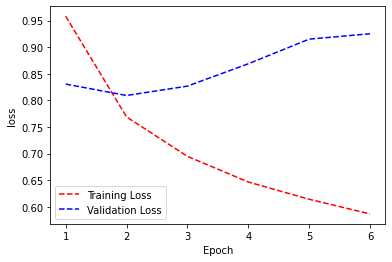

In [33]:
import matplotlib.pyplot as plt

epoch_count = range(1 , len(history.history['loss'])+1)

plt.plot(epoch_count, history.history['loss'] , 'r--')
plt.plot(epoch_count, history.history['val_loss'] , 'b--')
plt.legend(['Training Loss' , 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()